Mounted files:
['dataset.zip']
Extracted dataset to unzipped_data
Detected nested 'dataset' folder, adjusting path...
Loading data...
Loaded 89 samples.
Training model...
Epoch 1/50


2025-06-02 06:43:44.253740: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.3021 - loss: 1.2416 - val_accuracy: 0.9333 - val_loss: 0.4816
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8199 - loss: 0.5060 - val_accuracy: 0.8667 - val_loss: 0.3900
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9658 - loss: 0.3061 - val_accuracy: 0.8667 - val_loss: 0.3543
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9539 - loss: 0.2425 - val_accuracy: 0.8667 - val_loss: 0.3573
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9658 - loss: 0.1867 - val_accuracy: 0.8667 - val_loss: 0.3558
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9777 - loss: 0.1250 - val_accuracy: 0.8667 - val_loss: 0.3558
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0914 - val_accuracy: 0.8667 - val_loss: 0.3581
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9881 - loss: 0.0767 - val_accuracy: 0.8667 - val_loss: 0.3607
Epoch 9/50

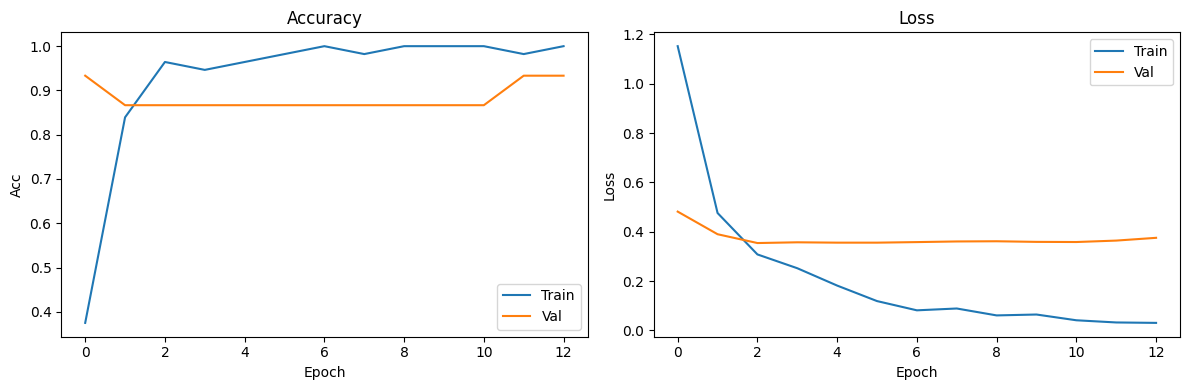

Saved model to wand_model.h5


In [8]:
import os
import zipfile
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from azureml.core import Workspace, Dataset, Run

# === 配置 ===
GESTURE_CLASSES = ["HorizontalSlash", "VerticalSlash", "DiagonalSlash"]
SEQUENCE_LENGTH = 100
MODEL_SAVE_PATH = "wand_model.h5"
ZIP_DATASET_NAME = "dataset.zip"
EXTRACTED_DATA_DIR = "unzipped_data"

def unzip_data(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted dataset to {extract_to}")

def adjust_path_if_nested(base_dir):
    nested = os.path.join(base_dir, "dataset")
    if os.path.isdir(nested):
        print("Detected nested 'dataset' folder, adjusting path...")
        return nested
    return base_dir

def load_data_from_directory(directory):
    features, labels = [], []
    for idx, class_name in enumerate(GESTURE_CLASSES):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            print(f"Missing: {class_dir}")
            continue
        for file_name in os.listdir(class_dir):
            if file_name.endswith('.csv'):
                try:
                    df = pd.read_csv(os.path.join(class_dir, file_name))
                    if not {'x', 'y', 'z'}.issubset(df.columns):
                        continue
                    sequence = df[['x', 'y', 'z']].values.tolist()
                    if len(sequence) >= SEQUENCE_LENGTH:
                        features.append(sequence[:SEQUENCE_LENGTH])
                        labels.append(idx)
                    elif len(sequence) > 10:
                        padded = sequence + [[0, 0, 0]] * (SEQUENCE_LENGTH - len(sequence))
                        features.append(padded)
                        labels.append(idx)
                except Exception as e:
                    print(f"Error with {file_name}: {e}")
    return np.array(features), np.array(labels)

def preprocess_data(features, labels):
    n_samples = features.shape[0]
    features_flat = features.reshape(n_samples, -1)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_flat)
    return train_test_split(features_scaled, labels, test_size=0.2, stratify=labels)

def build_model(input_dim, num_classes):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_training(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def main():
    run = Run.get_context()
    if hasattr(run, "experiment"):
        ws = run.experiment.workspace
    else:
        ws = Workspace.from_config()

    dataset = Dataset.File.from_files(path=(ws.get_default_datastore(), 'UI/2025-06-02_062516_UTC/'))
    mount_context = dataset.mount()
    mount_context.start()

    try:
        print("Mounted files:")
        print(os.listdir(mount_context.mount_point))

        zip_path = os.path.join(mount_context.mount_point, ZIP_DATASET_NAME)
        unzip_data(zip_path, EXTRACTED_DATA_DIR)

        real_data_dir = adjust_path_if_nested(EXTRACTED_DATA_DIR)

        print("Loading data...")
        features, labels = load_data_from_directory(real_data_dir)
        if len(features) == 0:
            print("No usable data found.")
            return

        print(f"Loaded {len(features)} samples.")
        X_train, X_test, y_train, y_test = preprocess_data(features, labels)
        model = build_model(X_train.shape[1], len(GESTURE_CLASSES))

        print("Training model...")
        history = model.fit(
            X_train, y_train, epochs=50, batch_size=32, validation_split=0.2,
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
        )

        print("Evaluating...")
        test_loss, test_acc = model.evaluate(X_test, y_test)
        run.log("Test Accuracy", test_acc)
        run.log("Test Loss", test_loss)
        print(f"Test accuracy: {test_acc:.4f}")

        plot_training(history)
        model.save(MODEL_SAVE_PATH)
        print(f"Saved model to {MODEL_SAVE_PATH}")

    finally:
        mount_context.stop()

if __name__ == "__main__":
    main()